In [1]:
import os
import re
from collections import Counter
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
cm = 1/2.54

# force GPU device
os.environ["CUDA_VISIBLE_DEVICES"]='1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout, Bidirectional, Embedding, Input, RepeatVector, TimeDistributed, Reshape
from keras import Sequential, Model
from keras.losses import CategoricalCrossentropy, CategoricalFocalCrossentropy, SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras.models import load_model
from keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from utils import *

In [2]:
data_directory = '/home/jrosendahl/datasets/cadets/sequences_export_benign_filetypes_path_ts/'
experiment_name = 'path_autoencoder_v2'

checkpoint_path = f'saves/{experiment_name}'
model_path = f'{checkpoint_path}/model.keras'
log_path = f'{checkpoint_path}/log.csv'
history_path = f'{checkpoint_path}/history.npy'

# ensure directory exists
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

In [3]:
# list of limitations for paths:
# allowed charaters: alphanumeric chars + '/.'
# all chars are transformed to lowercase
def preprocess_path(path: str) -> str:
    path = path.lower()
    path = re.sub(r'[^a-z0-9/._]', '', path)
    return path

In [4]:
# load data

vocab = set()
X = []
longest_path = 0
files_loaded = 0

for filename in os.listdir(data_directory):
    with open(os.path.join(data_directory, filename), 'r') as f:
        files_loaded += 1
        if files_loaded % 50000 == 0:
            print(f"Files loaded: {files_loaded}")

        for line in f:
            line = line.split(',')
            path1 = line[4]
            path2 = line[5]


            for path in [path1, path2]:
                if path in ['', 'None']:
                    continue
                path = preprocess_path(path1)
                vocab.update(path)
                X.append(path)


mean_length = np.mean([len(path) for path in X])
vocab_size = len(vocab)

char_to_idx = {char: idx+1 for idx, char in enumerate(vocab)}
# add padding character
char_to_idx[''] = 0
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

print(f"Files loaded: {files_loaded}")
print(f'{len(X)=}')
print(f'{vocab_size=}')
print(f'{longest_path=}')
print(f'{mean_length=}')

Files loaded: 50000
Files loaded: 100000
Files loaded: 150000
Files loaded: 200000
Files loaded: 215150
len(X)=8161337
vocab_size=39
longest_path=0
mean_length=16.37407400282576


In [5]:
fixed_length = 50

def vectorize_data(X, char_to_idx, fixed_length):
    X_vec = np.zeros((len(X), fixed_length), dtype=np.int32)
    for i, path in enumerate(X):
        for j, char in enumerate(path):
            if j >= fixed_length:
                break
            X_vec[i, j] = char_to_idx[char]
    return X_vec

def vectorized_to_string(X, idx_to_char):
    return [''.join([idx_to_char[idx] for idx in path]) for path in X]

X_vec = vectorize_data(X, char_to_idx, fixed_length)

In [ ]:
def output_to_string(output: np.ndarray, idx_to_char: dict) -> str:
    output_argmax = np.argmax(output, axis=-1)
    return vectorized_to_string(output_argmax, idx_to_char)

In [6]:
print(f'{X_vec.shape=}')
print(f'{X_vec[0]=}')

X_vec.shape=(8161337, 50)
X_vec[0]=array([ 1, 33, 18, 39,  1, 28, 36, 14,  1,  2,  7,  3,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)


In [7]:
class DataGenerator(Sequence):
    def __init__(self, data, batch_size, fixed_length, vocab_size, shuffle=True):
        # call super
        super(DataGenerator, self).__init__()
        self.data = data
        self.batch_size = batch_size
        self.fixed_length = fixed_length
        self.vocab_size = vocab_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        # Generate indices for the batch
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        # Generate data for the batch
        X_batch = self.__data_generation(batch_indices)

        # Since it's an autoencoder, the target data is the same as the input data
        return X_batch, X_batch

    def on_epoch_end(self):
        # Shuffle indices after each epoch if shuffle is True
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_indices):
        # Generate data for a batch of given indices
        # This is where you can customize your data loading and processing
        batch_data = [self.data[i] for i in batch_indices]

        # Convert the batch data to a numpy array (or whatever format is needed)
        X_batch = np.array(batch_data)

        # Ensure the data is padded or truncated to fixed_length
        X_batch = np.array([np.pad(x, (0, max(0, self.fixed_length - len(x))), constant_values=0)[:self.fixed_length] for x in X_batch])

        return X_batch

In [8]:
# prep data generators
batch_size = 512
train_size = int(0.8 * len(X_vec))
val_size = int(0.15 * len(X_vec))
test_size = len(X_vec) - train_size - val_size

train_gen = DataGenerator(X_vec[:train_size], batch_size, fixed_length, vocab_size)
val_gen = DataGenerator(X_vec[train_size:train_size+val_size], batch_size, fixed_length, vocab_size)
test_gen = DataGenerator(X_vec[train_size+val_size:], batch_size, fixed_length, vocab_size)

x_gen = DataGenerator(X_vec, batch_size, fixed_length, vocab_size)

In [42]:
# build model
def build_autoencoder(vocab_size, fixed_length, latent_dim, hidden_dim, recurrent_layers):
    encoder_input = Input(shape=(fixed_length,))
    x = Embedding(input_dim=vocab_size+1, output_dim=hidden_dim)(encoder_input)

    for i in range(recurrent_layers):
        if i == recurrent_layers - 1:
            # Last LSTM layer should not return sequences
            x = LSTM(hidden_dim, return_sequences=False)(x)
        else:
            x = LSTM(hidden_dim, return_sequences=True)(x)

    latent_output = Dense(latent_dim, activation='relu')(x)

    # Create the encoder model
    encoder = Model(encoder_input, latent_output, name='encoder')

    # Decoder definition
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(hidden_dim, activation='relu')(decoder_input)
    x = RepeatVector(fixed_length)(x)
    for i in range(recurrent_layers):
        x = LSTM(hidden_dim, return_sequences=True)(x)

    decoder_output = TimeDistributed(Dense(vocab_size+1, activation='softmax'))(x)

    # Create the decoder model
    decoder = Model(decoder_input, decoder_output, name='decoder')

    # Autoencoder definition
    autoencoder_input = encoder_input
    encoded_sequence = encoder(autoencoder_input)
    decoded_sequence = decoder(encoded_sequence)

    # Create the autoencoder model by combining encoder and decoder
    autoencoder = Model(autoencoder_input, decoded_sequence, name='autoencoder')

    autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return encoder, decoder, autoencoder

In [43]:
encoder, decoder, autoencoder = build_autoencoder(
    vocab_size=vocab_size,        # Example vocab size
    fixed_length=fixed_length,      # Example fixed length
    latent_dim=48,        # Latent space dimension
    hidden_dim=128,       # Number of neurons in hidden layers
    recurrent_layers=3     # Number of LSTM layers in encoder and decoder
)

encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 50, 128)        │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 48)             │         6,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,064 (1.55 MB)

 Trainable params: 406,064 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_6 (RepeatVector)  │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 50, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 50, 40)         │         5,160 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,184 (1.55 MB)

 Trainable params: 406,184 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 48)             │       406,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 50, 40)         │       406,184 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,248 (3.10 MB)

 Trainable params: 812,248 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        model_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1
    ),
    CSVLogger(log_path)
]

# metrics
metrics = [
    CategoricalAccuracy(),
    TopKCategoricalAccuracy(k=3),
]

In [29]:
# training
history = autoencoder.fit(
    train_gen,
    validation_data=val_gen,
    epochs=1,
    callbacks=callbacks,
    verbose=1,
)

# save model
encoder.save(f'{checkpoint_path}/encoder.keras')
decoder.save(f'{checkpoint_path}/decoder.keras')
autoencoder.save(f'{checkpoint_path}/autoencoder.keras')

12751/12752 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8933 - loss: 0.4050
Epoch 1: val_loss improved from inf to 0.12713, saving model to saves/path_autoencoder_v2/model.keras
12752/12752 ━━━━━━━━━━━━━━━━━━━━ 596s 46ms/step - accuracy: 0.8933 - loss: 0.4050 - val_accuracy: 0.9657 - val_loss: 0.1271 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


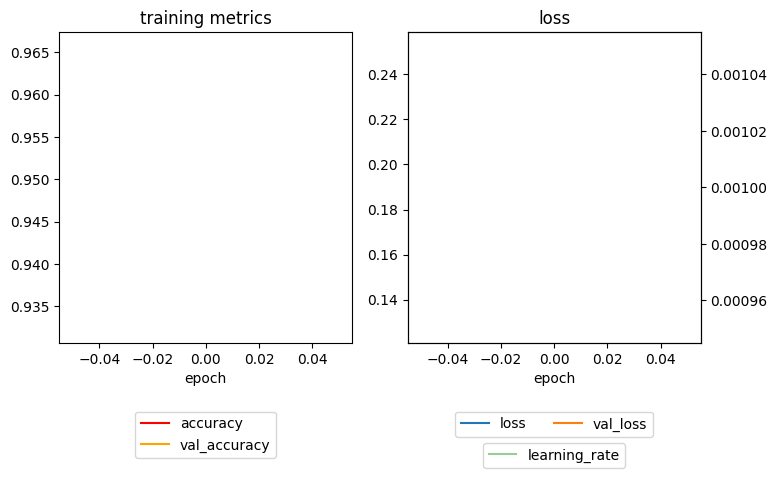

In [31]:
log = pd.read_csv(log_path)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20*cm, 15*cm))

ax1.plot(log['epoch'], log['accuracy'], label='accuracy', color='red')
ax1.plot(log['epoch'], log['val_accuracy'], label='val_accuracy', color='orange')
ax1.set_title('training metrics')
ax1.set_xlabel('epoch')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)  # Legend below the plot

ax2.plot(log['epoch'], log['loss'], label='loss')
ax2.plot(log['epoch'], log['val_loss'], label='val_loss')
# plot learning rate with different scale, show on right side
ax2b = ax2.twinx()
ax2b.plot(log['epoch'], log['learning_rate'], label='learning_rate', color='green', alpha=.4)
ax2.set_title('loss')
ax2.set_xlabel('epoch')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)  # Legend below the plot
ax2b.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)  # Legend below the plot

fig.tight_layout(rect=[0, 0.1, 1, 1])

plt.savefig(f'{checkpoint_path}/metrics_loss.svg')
plt.show()

In [ ]:
# evaluate model on test data
test_loss = autoencoder.evaluate(test_gen, verbose=1)

print(f'Test loss: {test_loss}')

In [34]:
autoencoder_file = load_model(f'{checkpoint_path}/autoencoder.keras')

test_loss = autoencoder_file.evaluate(test_gen, verbose=1)

print(f'Test loss: {test_loss}')

797/797 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.8831 - loss: 0.4315
Test loss: [0.43147316575050354, 0.8830505013465881]


In [41]:
# test out encoder and decoder separately from file
encoder_file = load_model(f'{checkpoint_path}/encoder.keras')
decoder_file = load_model(f'{checkpoint_path}/decoder.keras')

# select a random sample from the test data
sample_idx = np.random.randint(0, len(test_gen))
sample = test_gen[sample_idx][0]

# encode the sample
encoded_sample = encoder_file.predict(sample)
print(f'{encoded_sample.shape=}')
print(f'{encoded_sample[0]=}')

# decode the sample
decoded_sample = decoder_file.predict(encoded_sample)
print(f'{decoded_sample.shape=}')
print(f'{decoded_sample[0]=}')

# convert the sample to strings
sample_str = vectorized_to_string(sample, idx_to_char)
decoded_sample_str = output_to_string(decoded_sample, idx_to_char)

print(f'{sample_str[0]=}')
print(f'{decoded_sample_str[0]=}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
encoded_sample.shape=(512, 48)
encoded_sample[0]=array([0.        , 0.        , 0.26421764, 0.        , 1.8117366 ,
       1.8628339 , 0.10177945, 0.        , 0.        , 0.67529345,
       0.        , 0.        , 0.8968353 , 0.        , 0.        ,
       0.        , 0.34061122, 0.        , 0.        , 0.        ,
       0.32012925, 0.        , 0.        , 0.        , 0.02531131,
       0.        , 1.0228505 , 0.        , 0.10524722, 0.        ,
       0.        , 0.        , 3.1811204 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.8879318 , 0.        , 0.        ], dtype=float32)
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
decoded_sample.shape=(512, 50, 40)
decoded_sample[0]=array([[2.74825743e-06, 9.99648094e-01, 6.03773628e-07, ...,
        1.23066491e-06, 7.84621363e-07, 3.06059427e-08],
       [4.39110295e-08, 3.42472572e-06, 